# ECE 276C HW3 P1
Mingwei Xu A53270271

In [14]:
import gym
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.distributions import Categorical

## Define Network

In [15]:
class PolicyNetwork(nn.Module):
    """
    Policy Network using MLP
    """
    def __init__(self, env):
        """
        :param env: object, gym environment
        """
        super(PolicyNetwork, self).__init__()
        # get state space and action space dimension
        self.state_space_n = env.observation_space.shape[0]
        self.action_space_n = env.action_space.n

        # define layers
        self.l1 = nn.Linear(self.state_space_n, 48)
        self.l2 = nn.Linear(48, self.action_space_n)

    def forward(self, x):
        """
        Feed forward
        
        :param x: np array, state
        :return: tensor, softmax probability of action
        """
        # build neural network
        network = nn.Sequential(
            self.l1,
            nn.Softmax(dim=-1),
            self.l2,
            nn.Softmax(dim=-1))

        return network(torch.FloatTensor(x).to(device))

## Choose Action

In [16]:
def choose_action(policy_network, state):
    """
    Choose action according to policy on given state

    :param policy_network: object, policy network
    :param state: np array, state
    :returns: int, action; tensor, log probability
    """
    probs = policy_network.forward(state)
    m = Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    return action.item(), log_prob

## Setup CUDA

In [17]:
# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device :', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device : cuda
GeForce GTX 1080


## Question 1.1

In [18]:
def reinforce(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99):
    """
    Policy gradient training using reinforce method

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    :return: list of average reward on each episode
    """
    # setup place holders
    average_reward_list = []  # store step over episode

    # define optimizer
    optimizer = optim.Adam(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders for each batch
        batch_loss_sum = 0
        batch_traj_counter = 0
        batch_rewards = []

        # setup placeholders for each trajectory
        traj_rewards = []
        traj_log_prob_sum = 0

        # reset environment
        state = env.reset()
        done = False

        # batch
        for step in range(batch_size):
            # exploration
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)
            # env.render()

            # store data
            traj_rewards.append(reward)
            traj_log_prob_sum += log_prob

            # move on
            if done or (step == batch_size - 1):
                # trajectory or batch finished, update trajectory
                traj_discounted_return = torch.sum(torch.FloatTensor(traj_rewards).to(device) *
                                                   torch.FloatTensor([gamma ** t for t in range(1, len(traj_rewards) + 1)]).to(device))  # G(t)
                batch_loss_sum += traj_discounted_return * traj_log_prob_sum
                
                # reset state
                batch_rewards.append(np.sum(traj_rewards))
                batch_traj_counter += 1

                traj_rewards = []
                traj_log_prob_sum = 0

                state = env.reset()
            else:
                state = state_next

        # finish batch
        average_batch_reward = np.mean(batch_rewards)
        average_reward_list.append(average_batch_reward)
        loss = - batch_loss_sum / batch_traj_counter
        
        print('Episode [{}/{}] loss: {:.2f}, average reward: {:.2f}, trajectory num: {}'.format(i + 1, num_episodes,
                               loss.item(), average_batch_reward, batch_traj_counter))

        # update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return average_reward_list

### Training

In [19]:
# setup environment
env = gym.make('CartPole-v1')
state = env.reset()

# setup network
policy_network = PolicyNetwork(env).to(device)

# train
average_reward_list = reinforce(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99)

Episode [1/200] loss: 316.65, average reward: 20.83, trajectory num: 24
Episode [2/200] loss: 358.43, average reward: 22.73, trajectory num: 22
Episode [3/200] loss: 588.35, average reward: 27.78, trajectory num: 18
Episode [4/200] loss: 256.73, average reward: 18.52, trajectory num: 27
Episode [5/200] loss: 340.64, average reward: 20.83, trajectory num: 24
Episode [6/200] loss: 320.27, average reward: 20.83, trajectory num: 24
Episode [7/200] loss: 359.06, average reward: 20.83, trajectory num: 24
Episode [8/200] loss: 305.40, average reward: 20.83, trajectory num: 24
Episode [9/200] loss: 302.77, average reward: 20.83, trajectory num: 24
Episode [10/200] loss: 372.55, average reward: 21.74, trajectory num: 23
Episode [11/200] loss: 369.20, average reward: 22.73, trajectory num: 22
Episode [12/200] loss: 270.49, average reward: 19.23, trajectory num: 26
Episode [13/200] loss: 257.27, average reward: 19.23, trajectory num: 26
Episode [14/200] loss: 268.83, average reward: 19.23, trajec

Episode [114/200] loss: 1435.46, average reward: 50.00, trajectory num: 10
Episode [115/200] loss: 1625.83, average reward: 55.56, trajectory num: 9
Episode [116/200] loss: 1415.79, average reward: 50.00, trajectory num: 10
Episode [117/200] loss: 1510.30, average reward: 50.00, trajectory num: 10
Episode [118/200] loss: 2024.75, average reward: 55.56, trajectory num: 9
Episode [119/200] loss: 913.98, average reward: 38.46, trajectory num: 13
Episode [120/200] loss: 1832.05, average reward: 55.56, trajectory num: 9
Episode [121/200] loss: 933.43, average reward: 38.46, trajectory num: 13
Episode [122/200] loss: 1752.50, average reward: 55.56, trajectory num: 9
Episode [123/200] loss: 2196.49, average reward: 62.50, trajectory num: 8
Episode [124/200] loss: 1976.89, average reward: 62.50, trajectory num: 8
Episode [125/200] loss: 1393.83, average reward: 50.00, trajectory num: 10
Episode [126/200] loss: 858.07, average reward: 38.46, trajectory num: 13
Episode [127/200] loss: 1839.88, a

### Plot

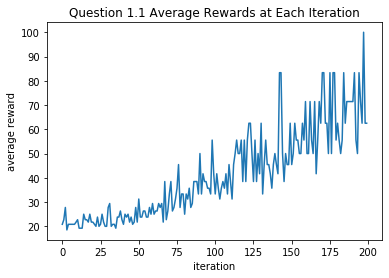

In [20]:
%matplotlib inline
plt.figure()
plt.plot(average_reward_list)
plt.xlabel('iteration')
plt.ylabel('average reward')
plt.title('Question 1.1 Average Rewards at Each Iteration')
plt.savefig('Question_1-1.png')
plt.show()

## Question 1.2

In [21]:
def reinforce_with_baseline(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99, enable_baseline=False):
    """
    Policy gradient training using modified reinforce method with baseline

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    :param enable_baseline: bool, flag to enable baseline, defaults to False
    :return: list of average reward on each episode
    """
    # setup place holders
    average_reward_list = []  # store step over episode

    # define optimizer
    optimizer = optim.Adam(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders for each batch
        batch_loss_sum = 0
        batch_traj_counter = 0
        batch_rewards = []

        # setup placeholders for each trajectory
        traj_loss_sum = 0
        traj_rewards = []
        traj_log_prob_list = []

        # reset environment
        state = env.reset()
        done = False

        # batch
        for step in range(batch_size):
            # exploration
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)
            # env.render()

            # store data
            traj_rewards.append(reward)
            traj_log_prob_list.append(log_prob)

            # move on
            if done or (step == batch_size - 1):
                # trajectory or batch finished, update trajectory
                # discounted_return_list = []
                discounted_return_list = [sum([gamma ** (t_prime - t) * traj_rewards[t_prime] for t_prime in range(t, len(traj_rewards))]) \
                                          for t in range(len(traj_rewards))]
                if enable_baseline:
                    # substract discounted return list by its mean
                    discounted_return_list = np.array(discounted_return_list) - np.mean(discounted_return_list)

                # sum the traj loss by loop so we do not lose tensor gradient
                traj_loss_sum = 0
                for t in range(len(traj_log_prob_list)):
                    traj_loss_sum += traj_log_prob_list[t] * discounted_return_list[t]
                batch_loss_sum += traj_loss_sum
                
                # reset state
                batch_rewards.append(np.sum(traj_rewards))
                batch_traj_counter += 1

                traj_loss_sum = 0
                traj_rewards = []
                traj_log_prob_list = []

                state = env.reset()
            else:
                state = state_next

        # finish batch
        average_batch_reward = np.mean(batch_rewards)
        average_reward_list.append(average_batch_reward)
        loss = - batch_loss_sum / batch_traj_counter
        
        print('Episode [{}/{}] loss: {:.2f}, average reward: {:.2f}, trajectory num: {}'.format(i + 1, num_episodes,
                               loss.item(), average_batch_reward, batch_traj_counter))

        # update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return average_reward_list

### Training

In [22]:
# setup environment
env = gym.make('CartPole-v1')
state = env.reset()

# setup network
policy_network = PolicyNetwork(env).to(device)

# train
average_reward_list = reinforce_with_baseline(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99)

Episode [1/200] loss: 213.99, average reward: 23.81, trajectory num: 21
Episode [2/200] loss: 182.95, average reward: 21.74, trajectory num: 23
Episode [3/200] loss: 163.03, average reward: 20.83, trajectory num: 24
Episode [4/200] loss: 169.10, average reward: 20.83, trajectory num: 24
Episode [5/200] loss: 271.19, average reward: 26.32, trajectory num: 19
Episode [6/200] loss: 123.10, average reward: 17.86, trajectory num: 28
Episode [7/200] loss: 145.88, average reward: 19.23, trajectory num: 26
Episode [8/200] loss: 210.90, average reward: 21.74, trajectory num: 23
Episode [9/200] loss: 145.41, average reward: 19.23, trajectory num: 26
Episode [10/200] loss: 206.97, average reward: 23.81, trajectory num: 21
Episode [11/200] loss: 211.30, average reward: 22.73, trajectory num: 22
Episode [12/200] loss: 200.21, average reward: 20.83, trajectory num: 24
Episode [13/200] loss: 217.91, average reward: 22.73, trajectory num: 22
Episode [14/200] loss: 224.24, average reward: 22.73, trajec

Episode [114/200] loss: 920.56, average reward: 55.56, trajectory num: 9
Episode [115/200] loss: 1325.11, average reward: 62.50, trajectory num: 8
Episode [116/200] loss: 1822.68, average reward: 83.33, trajectory num: 6
Episode [117/200] loss: 1393.13, average reward: 71.43, trajectory num: 7
Episode [118/200] loss: 1209.71, average reward: 62.50, trajectory num: 8
Episode [119/200] loss: 1933.13, average reward: 83.33, trajectory num: 6
Episode [120/200] loss: 876.13, average reward: 55.56, trajectory num: 9
Episode [121/200] loss: 1205.35, average reward: 62.50, trajectory num: 8
Episode [122/200] loss: 938.20, average reward: 55.56, trajectory num: 9
Episode [123/200] loss: 1875.27, average reward: 83.33, trajectory num: 6
Episode [124/200] loss: 1968.97, average reward: 83.33, trajectory num: 6
Episode [125/200] loss: 1663.77, average reward: 71.43, trajectory num: 7
Episode [126/200] loss: 2434.75, average reward: 100.00, trajectory num: 5
Episode [127/200] loss: 1910.93, average

### Plot

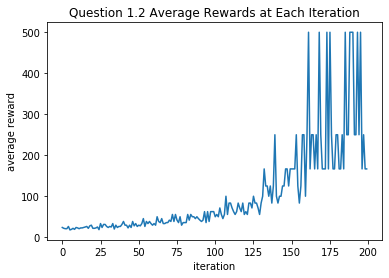

In [23]:
%matplotlib inline
plt.figure()
plt.plot(average_reward_list)
plt.xlabel('iteration')
plt.ylabel('average reward')
plt.title('Question 1.2 Average Rewards at Each Iteration')
plt.savefig('Question_1-2.png')
plt.show()

## Question 1.3                                                                                                         

### Training

In [24]:
# setup environment
env = gym.make('CartPole-v1')
state = env.reset()

# setup network
policy_network = PolicyNetwork(env).to(device)

# train
average_reward_list = reinforce_with_baseline(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99, enable_baseline=True)

Episode [1/200] loss: 0.03, average reward: 23.81, trajectory num: 21
Episode [2/200] loss: 0.05, average reward: 19.23, trajectory num: 26
Episode [3/200] loss: -0.01, average reward: 20.00, trajectory num: 25
Episode [4/200] loss: -0.30, average reward: 29.41, trajectory num: 17
Episode [5/200] loss: 0.08, average reward: 17.86, trajectory num: 28
Episode [6/200] loss: 0.01, average reward: 25.00, trajectory num: 20
Episode [7/200] loss: -0.20, average reward: 21.74, trajectory num: 23
Episode [8/200] loss: -0.17, average reward: 26.32, trajectory num: 19
Episode [9/200] loss: -0.24, average reward: 22.73, trajectory num: 22
Episode [10/200] loss: 0.12, average reward: 23.81, trajectory num: 21
Episode [11/200] loss: -0.52, average reward: 26.32, trajectory num: 19
Episode [12/200] loss: -0.43, average reward: 23.81, trajectory num: 21
Episode [13/200] loss: -0.99, average reward: 26.32, trajectory num: 19
Episode [14/200] loss: 0.10, average reward: 21.74, trajectory num: 23
Episode

Episode [116/200] loss: 4.16, average reward: 62.50, trajectory num: 8
Episode [117/200] loss: -7.63, average reward: 71.43, trajectory num: 7
Episode [118/200] loss: 6.63, average reward: 55.56, trajectory num: 9
Episode [119/200] loss: 4.68, average reward: 71.43, trajectory num: 7
Episode [120/200] loss: 15.69, average reward: 62.50, trajectory num: 8
Episode [121/200] loss: -10.30, average reward: 50.00, trajectory num: 10
Episode [122/200] loss: -0.43, average reward: 83.33, trajectory num: 6
Episode [123/200] loss: 8.86, average reward: 71.43, trajectory num: 7
Episode [124/200] loss: 4.30, average reward: 55.56, trajectory num: 9
Episode [125/200] loss: -0.77, average reward: 41.67, trajectory num: 12
Episode [126/200] loss: -8.09, average reward: 62.50, trajectory num: 8
Episode [127/200] loss: -8.00, average reward: 62.50, trajectory num: 8
Episode [128/200] loss: -8.37, average reward: 55.56, trajectory num: 9
Episode [129/200] loss: 1.80, average reward: 62.50, trajectory nu

### Plot

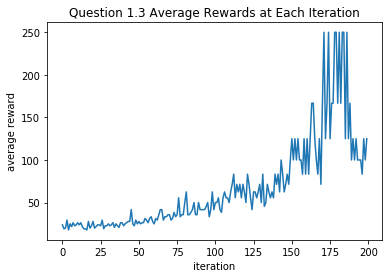

In [25]:
%matplotlib inline
plt.figure()
plt.plot(average_reward_list)
plt.xlabel('iteration')
plt.ylabel('average reward')
plt.title('Question 1.3 Average Rewards at Each Iteration')
plt.savefig('Question_1-3.png')
plt.show()

## Question 1.4

### Training

In [26]:
batch_size_list = [600, 800, 1000]
average_reward_list_final = []

for batch_size in batch_size_list:
    print('\n***** batch size = {} *****\n'.format(batch_size))
    # setup environment
    env = gym.make('CartPole-v1')
    state = env.reset()

    # setup network
    policy_network = PolicyNetwork(env).to(device)

    # train
    average_reward_list_final.append(reinforce_with_baseline(env, policy_network, batch_size=batch_size, num_episodes=200, lr=0.01, gamma=0.99,                                                                                 enable_baseline=True))


***** batch size = 600 *****

Episode [1/200] loss: 0.67, average reward: 21.43, trajectory num: 28
Episode [2/200] loss: -0.16, average reward: 22.22, trajectory num: 27
Episode [3/200] loss: 0.13, average reward: 19.35, trajectory num: 31
Episode [4/200] loss: 0.33, average reward: 21.43, trajectory num: 28
Episode [5/200] loss: 0.29, average reward: 23.08, trajectory num: 26
Episode [6/200] loss: -0.23, average reward: 22.22, trajectory num: 27
Episode [7/200] loss: -0.13, average reward: 20.69, trajectory num: 29
Episode [8/200] loss: -0.02, average reward: 22.22, trajectory num: 27
Episode [9/200] loss: -0.19, average reward: 19.35, trajectory num: 31
Episode [10/200] loss: -0.17, average reward: 22.22, trajectory num: 27
Episode [11/200] loss: -0.20, average reward: 25.00, trajectory num: 24
Episode [12/200] loss: -0.23, average reward: 21.43, trajectory num: 28
Episode [13/200] loss: -0.31, average reward: 24.00, trajectory num: 25
Episode [14/200] loss: -0.07, average reward: 

Episode [115/200] loss: -15.59, average reward: 66.67, trajectory num: 9
Episode [116/200] loss: -30.34, average reward: 85.71, trajectory num: 7
Episode [117/200] loss: -24.21, average reward: 85.71, trajectory num: 7
Episode [118/200] loss: -51.96, average reward: 100.00, trajectory num: 6
Episode [119/200] loss: -31.74, average reward: 120.00, trajectory num: 5
Episode [120/200] loss: -61.36, average reward: 120.00, trajectory num: 5
Episode [121/200] loss: -24.08, average reward: 100.00, trajectory num: 6
Episode [122/200] loss: -9.54, average reward: 100.00, trajectory num: 6
Episode [123/200] loss: 21.08, average reward: 85.71, trajectory num: 7
Episode [124/200] loss: -7.45, average reward: 100.00, trajectory num: 6
Episode [125/200] loss: 11.72, average reward: 150.00, trajectory num: 4
Episode [126/200] loss: -53.40, average reward: 120.00, trajectory num: 5
Episode [127/200] loss: 27.70, average reward: 150.00, trajectory num: 4
Episode [128/200] loss: -20.71, average reward:

Episode [27/200] loss: -1.41, average reward: 27.59, trajectory num: 29
Episode [28/200] loss: -2.22, average reward: 30.77, trajectory num: 26
Episode [29/200] loss: -0.68, average reward: 25.00, trajectory num: 32
Episode [30/200] loss: -1.09, average reward: 30.77, trajectory num: 26
Episode [31/200] loss: -1.96, average reward: 23.53, trajectory num: 34
Episode [32/200] loss: -1.80, average reward: 25.00, trajectory num: 32
Episode [33/200] loss: -3.19, average reward: 27.59, trajectory num: 29
Episode [34/200] loss: -0.47, average reward: 21.62, trajectory num: 37
Episode [35/200] loss: -1.51, average reward: 27.59, trajectory num: 29
Episode [36/200] loss: -1.11, average reward: 27.59, trajectory num: 29
Episode [37/200] loss: -1.62, average reward: 26.67, trajectory num: 30
Episode [38/200] loss: 0.15, average reward: 33.33, trajectory num: 24
Episode [39/200] loss: 0.06, average reward: 25.00, trajectory num: 32
Episode [40/200] loss: -2.16, average reward: 28.57, trajectory nu

Episode [141/200] loss: 13.70, average reward: 266.67, trajectory num: 3
Episode [142/200] loss: 8.15, average reward: 200.00, trajectory num: 4
Episode [143/200] loss: -16.58, average reward: 200.00, trajectory num: 4
Episode [144/200] loss: -2.86, average reward: 200.00, trajectory num: 4
Episode [145/200] loss: -52.92, average reward: 133.33, trajectory num: 6
Episode [146/200] loss: -52.64, average reward: 200.00, trajectory num: 4
Episode [147/200] loss: -8.68, average reward: 200.00, trajectory num: 4
Episode [148/200] loss: -20.22, average reward: 200.00, trajectory num: 4
Episode [149/200] loss: -6.29, average reward: 200.00, trajectory num: 4
Episode [150/200] loss: -94.64, average reward: 400.00, trajectory num: 2
Episode [151/200] loss: 0.75, average reward: 200.00, trajectory num: 4
Episode [152/200] loss: -92.90, average reward: 266.67, trajectory num: 3
Episode [153/200] loss: -181.21, average reward: 266.67, trajectory num: 3
Episode [154/200] loss: -69.82, average rewar

Episode [54/200] loss: -7.05, average reward: 37.04, trajectory num: 27
Episode [55/200] loss: -3.61, average reward: 30.30, trajectory num: 33
Episode [56/200] loss: -3.61, average reward: 29.41, trajectory num: 34
Episode [57/200] loss: -3.69, average reward: 45.45, trajectory num: 22
Episode [58/200] loss: -1.72, average reward: 34.48, trajectory num: 29
Episode [59/200] loss: -8.72, average reward: 52.63, trajectory num: 19
Episode [60/200] loss: 0.36, average reward: 35.71, trajectory num: 28
Episode [61/200] loss: -7.06, average reward: 38.46, trajectory num: 26
Episode [62/200] loss: -6.49, average reward: 41.67, trajectory num: 24
Episode [63/200] loss: -1.90, average reward: 40.00, trajectory num: 25
Episode [64/200] loss: -2.66, average reward: 38.46, trajectory num: 26
Episode [65/200] loss: -1.76, average reward: 45.45, trajectory num: 22
Episode [66/200] loss: -9.19, average reward: 50.00, trajectory num: 20
Episode [67/200] loss: -4.39, average reward: 52.63, trajectory n

Episode [167/200] loss: 17.52, average reward: 333.33, trajectory num: 3
Episode [168/200] loss: 13.95, average reward: 500.00, trajectory num: 2
Episode [169/200] loss: 25.30, average reward: 333.33, trajectory num: 3
Episode [170/200] loss: -50.15, average reward: 333.33, trajectory num: 3
Episode [171/200] loss: 17.84, average reward: 250.00, trajectory num: 4
Episode [172/200] loss: 14.68, average reward: 333.33, trajectory num: 3
Episode [173/200] loss: -34.03, average reward: 333.33, trajectory num: 3
Episode [174/200] loss: -36.58, average reward: 333.33, trajectory num: 3
Episode [175/200] loss: -19.17, average reward: 250.00, trajectory num: 4
Episode [176/200] loss: -150.35, average reward: 333.33, trajectory num: 3
Episode [177/200] loss: 117.09, average reward: 500.00, trajectory num: 2
Episode [178/200] loss: -68.97, average reward: 250.00, trajectory num: 4
Episode [179/200] loss: -15.28, average reward: 333.33, trajectory num: 3
Episode [180/200] loss: -138.32, average r

### Plot

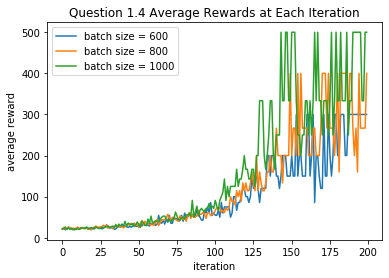

In [27]:
%matplotlib inline
plt.figure()
for average_reward_list in average_reward_list_final:
    plt.plot(average_reward_list)
plt.xlabel('iteration')
plt.ylabel('average reward')
plt.legend(['batch size = ' + str(batch_size) for batch_size in batch_size_list])
plt.title('Question 1.4 Average Rewards at Each Iteration')
plt.savefig('Question_1-4.png')
plt.show()